# Cycle Fucking Gan

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
#from losses import discriminator_loss, generator_loss, calc_cycle_loss, identity_loss
#from generator import Generator
#from discriminator import Discriminator
#from data_generator import load_dataset
#from cycleGAN import CycleGan
import matplotlib.pyplot as plt
import re
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

gpu = len(tf.config.list_physical_devices('GPU'))>0

if gpu:
    print("GPU is", "available")
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("NOT AVAILABLE")
    
AUTOTUNE = tf.data.experimental.AUTOTUNE

GPU is available


## Entrada dos Dados

In [2]:
GANDIDO_FILENAMES = tf.io.gfile.glob('gandido/*.jpeg')
print('Gandido Files:', len(GANDIDO_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('photo/*.jpeg')
print('Photo Files:', len(PHOTO_FILENAMES))

Gandido Files: 4580
Photo Files: 7038


In [3]:
IMAGE_SIZE = [256,256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32)/127.5) - 1
    
    image = tf.image.resize(image, IMAGE_SIZE,
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image = tf.reshape(image, [*IMAGE_SIZE,3])

    return image

def process(example):
    img = tf.io.read_file(example)

    image = decode_image(img)
    return image

In [4]:
def load_dataset(img_path, labeled=True, ordered=False):
    dataset = tf.data.Dataset.list_files(img_path)
    dataset = dataset.map(lambda x: process(x))
    return dataset

In [5]:
candido_datagen = tf.data.Dataset.list_files("./gandido/*.jpeg")
photo_datagen = tf.data.Dataset.list_files("./photo/*.jpeg")


candido_ds = candido_datagen.map(lambda x: process(x)).batch(4)

photo_ds = photo_datagen.map(lambda x: process(x)).batch(4)

In [6]:
example_candido = next(iter(candido_ds))
example_photo = next(iter(photo_ds))

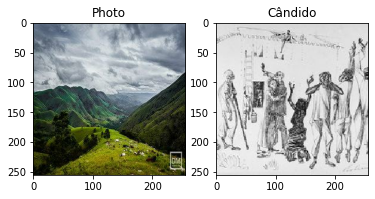

In [7]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0]* 0.5 + 0.5)

plt.subplot(122)
plt.title('Cândido')
plt.imshow(example_candido[0]* 0.5 + 0.5)

## Generator

In [8]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [9]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [10]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Discriminator

In [11]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [12]:
monet_generator = Generator() # transforms photos to Monet-esque paintings
photo_generator = Generator() # transforms Monet paintings to be more like photos

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos


## CycleGan

In [13]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Losses

In [14]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [15]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [16]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [17]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [18]:
gandido_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

gandido_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [19]:
gandido_generator = Generator()
photo_generator = Generator()

In [20]:
gandido_discriminator = Discriminator()
photo_discriminator = Discriminator()

In [21]:
cycle_gan_model = CycleGan(
    gandido_generator, photo_generator, gandido_discriminator, photo_discriminator
)

In [22]:
cycle_gan_model.compile(
    gandido_generator_optimizer,
    photo_generator_optimizer,
    gandido_discriminator_optimizer,
    photo_discriminator_optimizer,
    generator_loss,
    discriminator_loss,
    calc_cycle_loss,
    identity_loss
)

In [32]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((candido_ds, photo_ds)),
    epochs=10
)

Epoch 1/10
1145/1145 [==============================] - 953s 832ms/step - monet_gen_loss: 3.8974 - photo_gen_loss: 4.0453 - monet_disc_loss: 0.4880 - photo_disc_loss: 0.5269
Epoch 2/10
1145/1145 [==============================] - 949s 828ms/step - monet_gen_loss: 4.0812 - photo_gen_loss: 3.8985 - monet_disc_loss: 0.4264 - photo_disc_loss: 0.5596
Epoch 3/10
1145/1145 [==============================] - 950s 829ms/step - monet_gen_loss: 4.4456 - photo_gen_loss: 3.9072 - monet_disc_loss: 0.3508 - photo_disc_loss: 0.5433
Epoch 4/10
1145/1145 [==============================] - 951s 831ms/step - monet_gen_loss: 4.4260 - photo_gen_loss: 3.7916 - monet_disc_loss: 0.3552 - photo_disc_loss: 0.5497
Epoch 5/10
1145/1145 [==============================] - 953s 832ms/step - monet_gen_loss: 4.3588 - photo_gen_loss: 3.6817 - monet_disc_loss: 0.3515 - photo_disc_loss: 0.5526
Epoch 6/10
1145/1145 [==============================] - 954s 833ms/step - monet_gen_loss: 4.2942 - photo_gen_loss: 3.5849 - monet_

In [27]:
cycle_gan_model.save("best_model_mama_Aqui_Wallace.tf")

ValueError: Model <__main__.CycleGan object at 0x7fc52865f0a0> cannot be saved because the input shapes have not been set. Usually, input shapes are automatically determined from calling .fit() or .predict(). To manually set the shapes, call model._set_inputs(inputs).

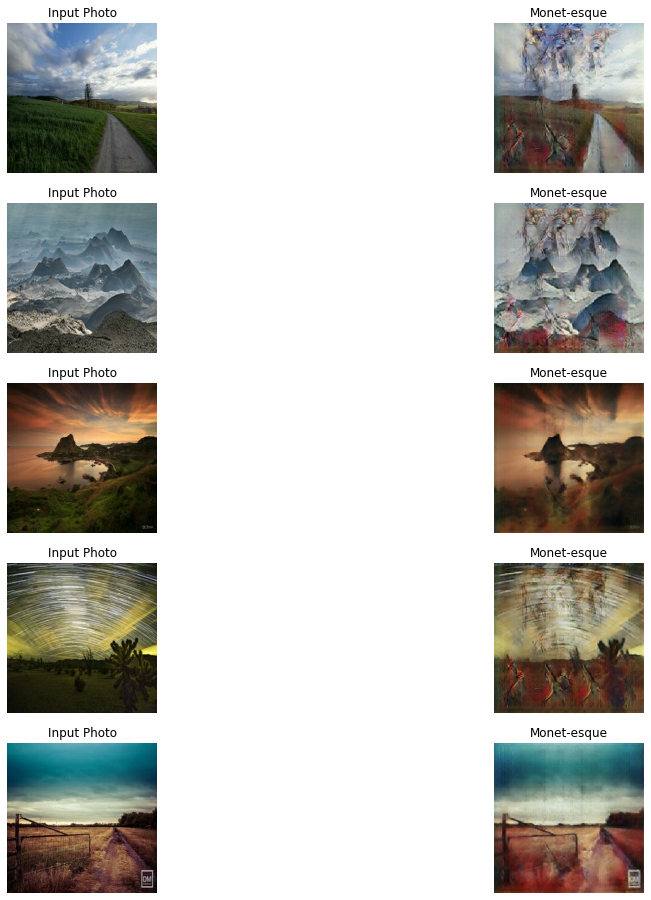

In [41]:
_, ax = plt.subplots(5, 2, figsize=(16, 16))
for i, img in enumerate(photo_ds.take(5)):
    prediction = gandido_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    plt.imsave(f'output/prediction_{i+40}.jpg', prediction)
    
plt.show()